# Natural Language Processing - Consumer Complaint in bank sector

## Research question: 

* How to develop an automatic text classification model that assigns customer complaints to the correct product categories based on their content?

Authors: Alam Jasia, Hubweber Michaela, Schumich Kathrin, Ye Florian

Dataset: https://www.kaggle.com/datasets/shashwatwork/consume-complaints-dataset-fo-nlp

## State of the Art

1. What has been researched so far?
* Classifying customer complaints into predefined categories using advanced NLP techniques
* Various machine learning and deep learning techniques
* Word embeddings to capture semantic relationships in complaint texts
* Studies show high accuracy in categorizing consumer complaints based on text
* Some approaches also use dimensionality reduction for better data visualization and grouping

2. What are common approaches/models?
* Traditional Methods:  Naïve Bayes, Decision Trees, Support Vector Machines, Generalized Linear Model
* More advanced approaches: LSTM, GRU, and CNN
* Word Embeddings (Word2Vec, BERT)
* Transformer Models (DistilBERT and FinBERT)
* Sentiment analysis to identify trends

Similar work and differences from ours? Existing research has explored the categorization of customer complaints, particularly through the use of NLP techniques to analyze text. However, our work **placeholder**

**References**
* Vinayak, V., & C., J. (2023). Consumer Complaints Classification using Deep Learning & Word Embedding Models. 2023 14th International Conference on Computing Communication and Networking Technologies (ICCCNT), 1-5.
* Kohler, M., Sondermann, L., Forero, L., & Pacheco, M.A. (2018). Classifying and Grouping Narratives with Convolutional Neural Networks, PCA and t-SNE. International Conference on Health Information Science.
* Research, M., & Rafiee, D.M. (2020). Analysis of Customer Complaint Data of Consumer Financial Protection Bureau Using Different Text Classification Methods.
* Correa, N., & Correa, A. (2022). Neural Text Classification for Digital Transformation in the Financial Regulatory Domain. 2022 IEEE ANDESCON, 1-6.



## CODE

### 0 Code Setup & Data Loading

#### Import all necessary packages 

In [1]:
import os
import re
# Ignore warnings
import warnings
import zipfile

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import spacy
from gensim.models import KeyedVectors, Word2Vec
from IPython.display import display
from scipy import stats
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import LabelEncoder  # For encoding labels
from spacy.cli import download
from textblob import TextBlob
from wordcloud import WordCloud

from narrative_to_vec import add_column_average_genre_vector, tokenize_column

warnings.filterwarnings('ignore')

/Users/michaela/anaconda3/envs/nlp/lib/python3.11/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:13: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm, trange


In [8]:
## load spacy language model or download it if not available
try:
    # Try to load the language model
    spacy_nlp = spacy.load("en_core_web_sm")
    print("Model loaded successfully.")
except OSError:
    # If the model is not available, download it using spacy.cli.download
    print("Model not found. Downloading...")
    download("en_core_web_sm")
    
    # After downloading, try loading again
    spacy_nlp = spacy.load("en_core_web_sm")
    print("Model downloaded and loaded successfully.")

Model loaded successfully.


In [2]:
# Get the data path
data_path = os.path.join("data", "raw.zip")
print(data_path)

data/raw.zip


## 1 Pre-Processing

* Cleaning
* Stemming
* Lemmatization
* Tokenization

Reading in the data and removing the index column.

In [3]:
# Load data & drop index column
data = pd.read_csv(data_path)
data = data.drop(data.columns[0], axis=1)

data.head()

,product,narrative
0,credit_card,purchase order day shipping amount receive pro...
1,credit_card,forwarded message date tue subject please inve...
2,retail_banking,forwarded message cc sent friday pdt subject f...
3,credit_reporting,payment history missing credit report speciali...
4,credit_reporting,payment history missing credit report made mis...


Check for missing values. Since only 10 out of 160k of the narratives are missing, they are simply removed.

In [4]:
# original number of rows
print("Number of rows: ", data.shape[0])
# missing values
print("Number of missing values: ", data.isnull().sum().sum())
data = data.dropna() #drop missing values
# number of rows after removing missing values
print("Number of rows after dropping missing values ", data.shape[0])

Number of rows:  162421
Number of missing values:  10
Number of rows after dropping missing values  162411


Check whether HTML tags, punctuation and numbers are present and whether content is written in Upper Case. Since this is not the case, no transformations are carried out in this sense.

In [5]:
print("Number of rows with html tags:", data['narrative'].str.contains('<.*?>', regex=True).sum())
print("Number of rows with punctuation:", data['narrative'].str.contains('[^\w\s]', regex=True).sum())
print("Number of rows with numbers:", data['narrative'].str.contains('\d', regex=True).sum())
print("Number of rows with uppercase:", data['narrative'].str.contains('[A-Z]', regex=True).sum())

Number of rows with html tags: 0
Number of rows with punctuation: 0
Number of rows with numbers: 0
Number of rows with uppercase: 0


In [6]:
# calculate the length of narrative (before preprocessing)
data['narrative_len'] = data['narrative'].apply(lambda text: len(text.split()))

Creating a new column that removes stop words from narrative. Remove the rows with less than 4 words in the new column as they are hardly meaningful and represent only a fraction of the total data

In [9]:
# create a columns for the cleaned narrative
stop_words = spacy.lang.en.stop_words.STOP_WORDS # define stop words

# remove stopwords
def remove_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in stop_words])

# assign to new column
data['narrative_prep'] = data['narrative'].apply(lambda text: remove_stopwords(text))

In [11]:
# number of rows that are empty after removing stop words
print("Number of rows with empty narratives after removing stop words:", data[data['narrative_prep'] == ''].shape[0])
# number of rows with narratives that have less than 4 words
print("Number of rows with narratives that have less than 4 words:", data[data['narrative_prep'].str.split().apply(len) < 4].shape[0])

# remove rows with narratives that have less than 4 words
data = data[data['narrative_prep'].str.split().apply(len) >= 4]

# show number of rows after removing rows
print("Number of rows after removing rows", data.shape[0])

Number of rows with empty narratives after removing stop words: 7
Number of rows with narratives that have less than 4 words: 1756
Number of rows after removing rows 160655


In [12]:
# Calculate the length of the new narrative
data['narrative_prep_len'] = data['narrative_prep'].apply(lambda text: len(text.split()))

Insight into the current dataframe before the exploratory data analysis is performed.

In [ ]:
data.head()

,product,narrative,narrative_len,narrative_prep,narrative_prep_len
0,credit_card,purchase order day shipping amount receive pro...,230,purchase order day shipping receive product we...,203
1,credit_card,forwarded message date tue subject please inve...,132,forwarded message date tue subject investigate...,121
2,retail_banking,forwarded message cc sent friday pdt subject f...,173,forwarded message cc sent friday pdt subject f...,147
3,credit_reporting,payment history missing credit report speciali...,131,payment history missing credit report speciali...,110
4,credit_reporting,payment history missing credit report made mis...,123,payment history missing credit report mistake ...,102


## 2 Explorative Data Analysis

In [13]:
# count occurrences of each product type
product_counts = data['product'].value_counts()
product_counts

product
credit_reporting       89748
debt_collection        22987
mortgages_and_loans    18955
credit_card            15530
retail_banking         13435
Name: count, dtype: int64

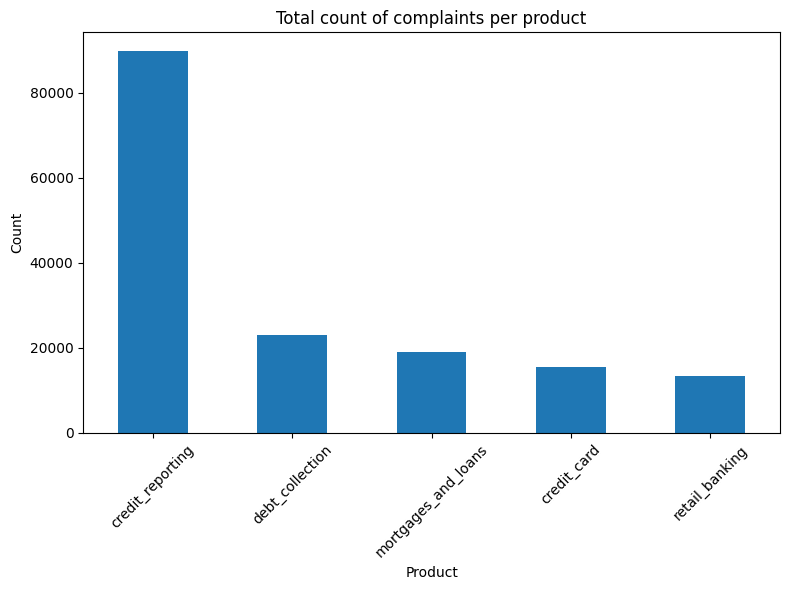

In [ ]:
# create a barchart by product
plt.figure(figsize=(8, 6))
product_counts.plot(kind='bar')
plt.title('Total count of complaints per product')
plt.xlabel('Product')
plt.ylabel('Count')
plt.xticks(rotation=45)  # rotate x-axis labels 
plt.tight_layout()  # better padding
plt.show()

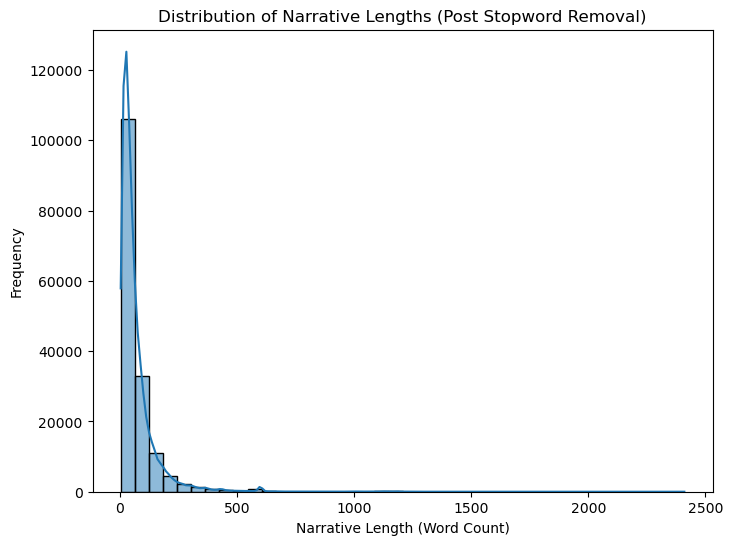

In [14]:
# distribution (histplot) of narrative lengths (after stopword removal)
plt.figure(figsize=(8, 6))
sns.histplot(data['narrative_prep_len'], bins=40, kde=True)
plt.title('Distribution of Narrative Lengths (Post Stopword Removal)')
plt.xlabel('Narrative Length (Word Count)')
plt.ylabel('Frequency')
plt.show()

In [15]:
# show summayr statistics for length_narrative_preprocessed
overall_summary = data['narrative_prep_len'].describe()
print("Overall Summary Statistics - length_narrative_preprocessed:")
display(overall_summary)

Overall Summary Statistics - length_narrative_preprocessed:


count    160655.000000
mean         71.113342
std          97.334293
min           4.000000
25%          24.000000
50%          44.000000
75%          83.000000
max        2410.000000
Name: narrative_prep_len, dtype: float64

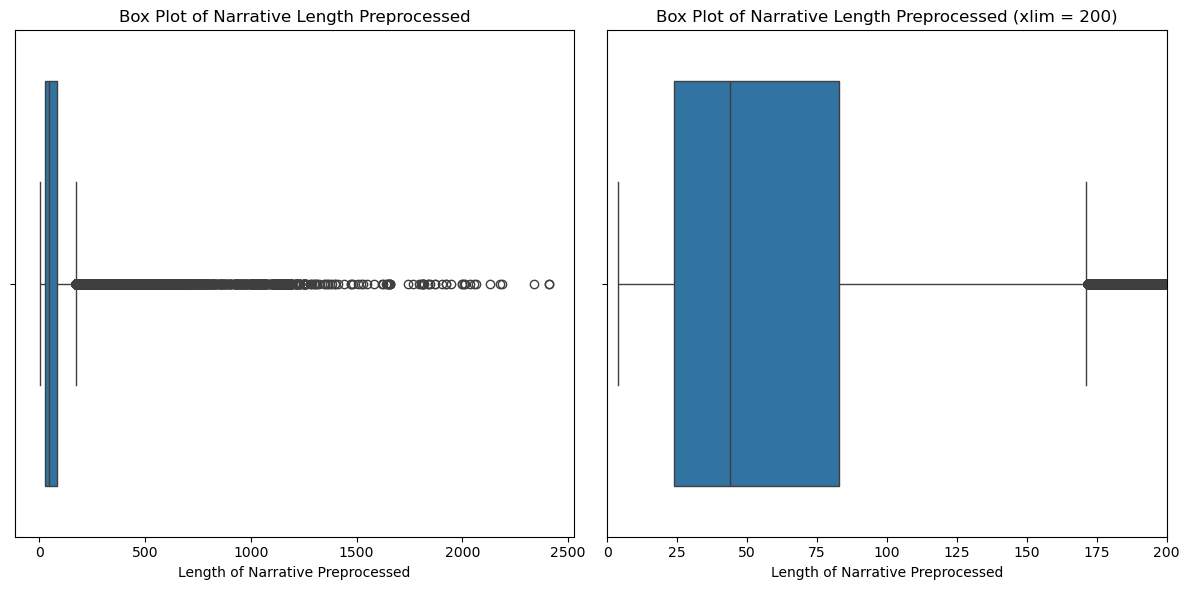

In [16]:
# side by side boxplots of narrative length (one is zoomed in)
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# first boxplot
sns.boxplot(x=data['narrative_prep_len'], ax=axes[0])  # Create the boxplot
axes[0].set_title('Box Plot of Narrative Length Preprocessed')
axes[0].set_xlabel('Length of Narrative Preprocessed')

# zoomed boxplot
sns.boxplot(x=data['narrative_prep_len'], ax=axes[1])  # Create the boxplot
axes[1].set_xlim(0, 200)  # Set the x-axis limit
axes[1].set_title('Box Plot of Narrative Length Preprocessed (xlim = 200)')
axes[1].set_xlabel('Length of Narrative Preprocessed')

plt.tight_layout()
plt.show()

In [17]:
# summary statistics grouped by product
grouped_summary = data.groupby('product')['narrative_prep_len'].describe()
print("\nGroup-wise Summary Statistics by Product:")
display(grouped_summary)


Group-wise Summary Statistics by Product:


,count,mean,std,min,25%,50%,75%,max
product,,,,,,,,
credit_card,15530.0,84.479395,85.383704,4.0,34.0,61.0,106.0,2038.0
credit_reporting,89748.0,61.205943,94.411572,4.0,21.0,36.0,65.0,2410.0
debt_collection,22987.0,69.811241,99.643645,4.0,23.0,44.0,83.0,2064.0
mortgages_and_loans,18955.0,101.391295,112.176236,4.0,41.0,72.0,121.0,2341.0
retail_banking,13435.0,81.355787,91.190146,4.0,28.0,57.0,101.0,1581.0


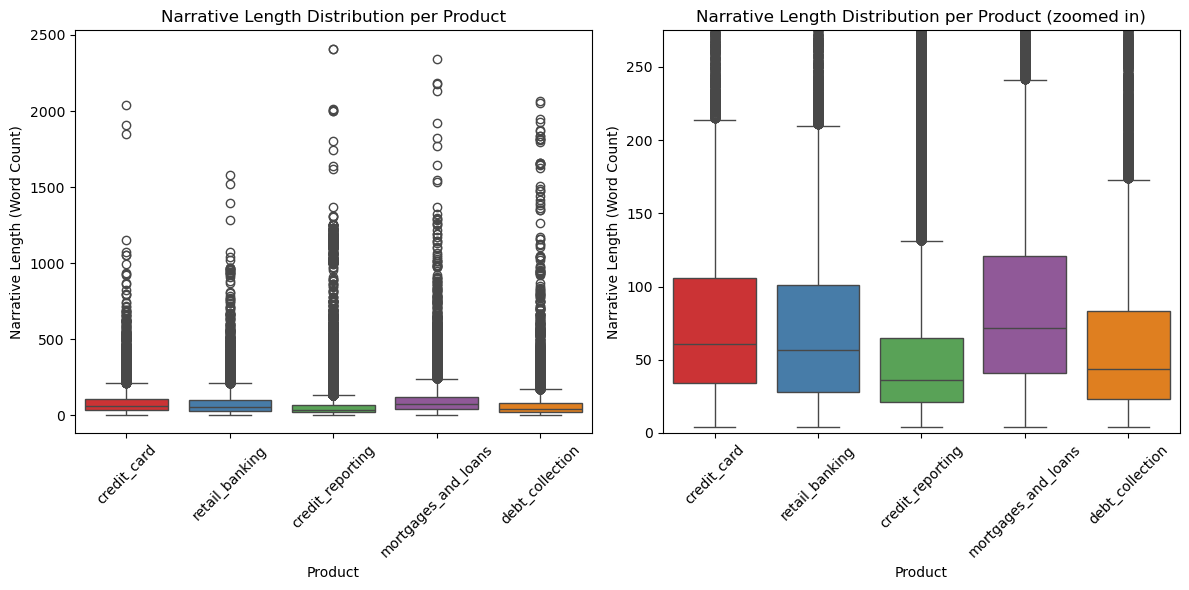

In [18]:
# boxplot of narrative length by product
def boxplot_narrative_length(data, title, ylim: int = None, ax=None):
    if ax is None:
        ax = plt.gca()
    sns.boxplot(x='product', y='narrative_prep_len', data=data, palette='Set1', ax=ax)
    ax.set_title(title)
    ax.set_xlabel('Product')
    ax.set_ylabel('Narrative Length (Word Count)')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    if ylim is not None:
        ax.set_ylim(0, ylim)

# create side by side boxplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# first boxplot
boxplot_narrative_length(data, title='Narrative Length Distribution per Product', ax=axes[0])

# zoomed in boxplot
boxplot_narrative_length(data, title='Narrative Length Distribution per Product (zoomed in)', ylim=275, ax=axes[1])

plt.tight_layout()
plt.show()

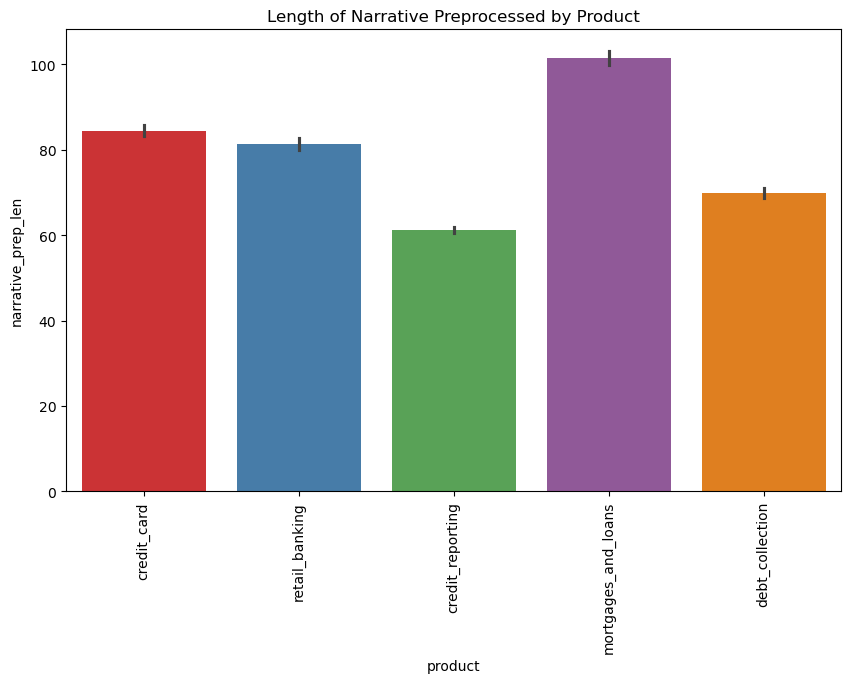

In [21]:
# bar chart of narrative length by product
plt.figure(figsize=(10,6))
sns.barplot(data=data, x='product', y='narrative_prep_len', palette ='Set1')
plt.xticks(rotation=90)
plt.title('Length of Narrative Preprocessed by Product')
plt.show()

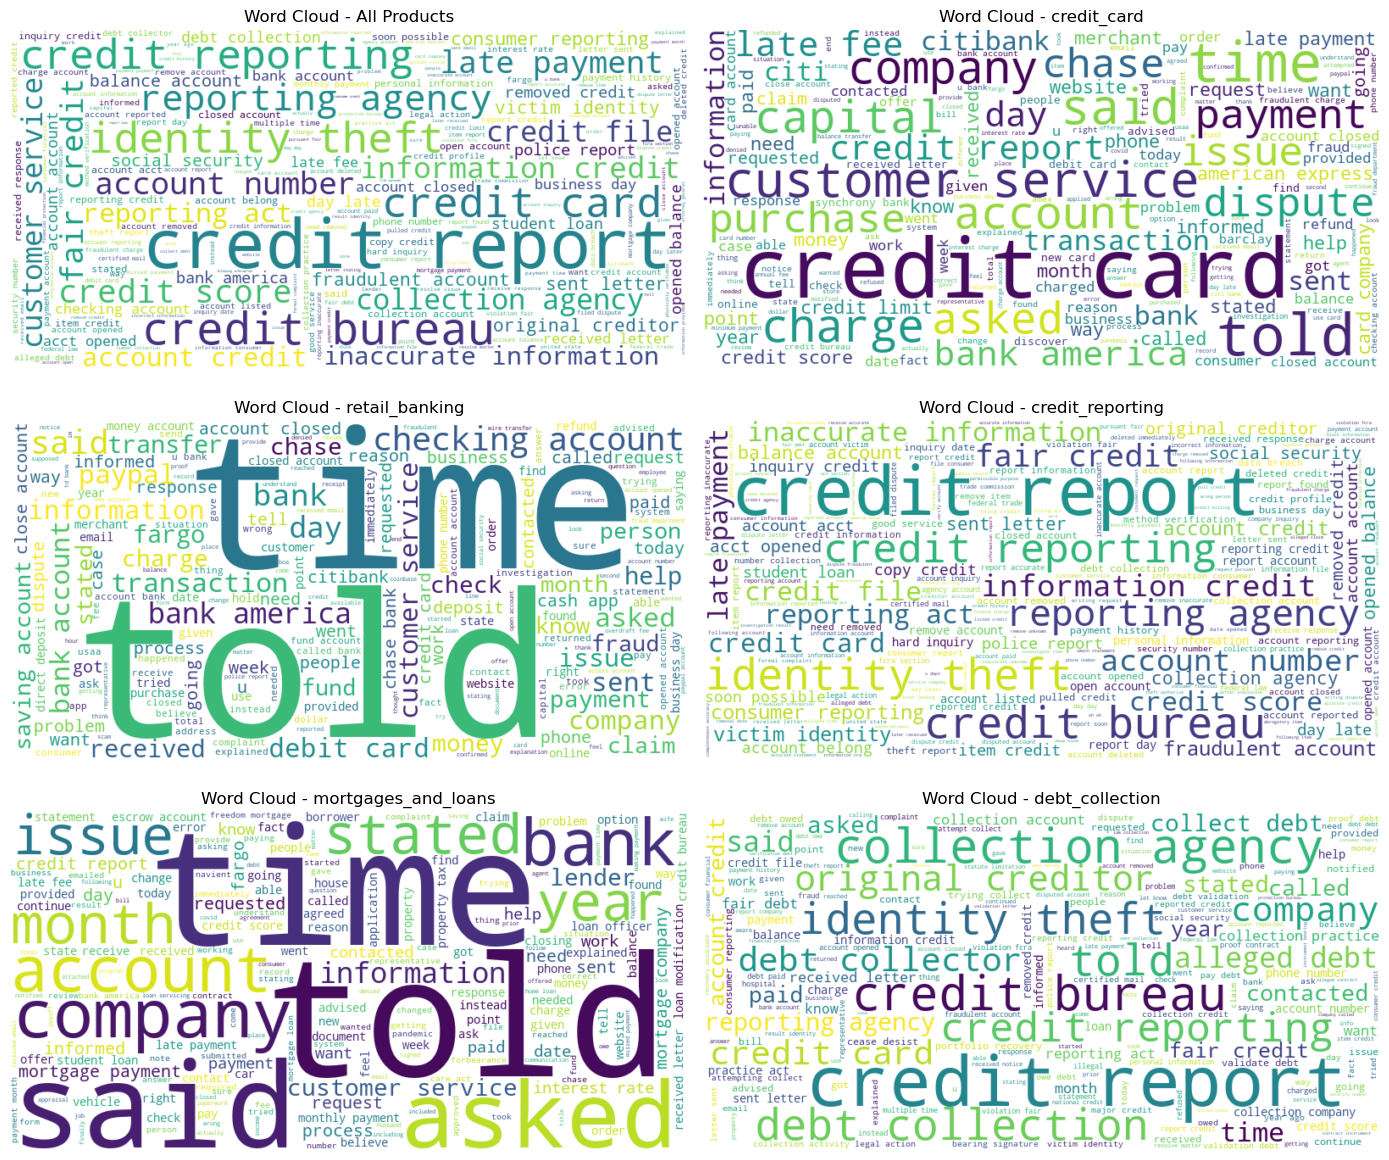

In [24]:
# subplots for word clouds for the entire dataset and five for each product category
fig, axes = plt.subplots(3, 2, figsize=(14, 12))

# word cloud for the whole dataset
all_words = ' '.join(data['narrative_prep'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_words)
axes[0, 0].imshow(wordcloud, interpolation='bilinear')
axes[0, 0].axis('off')
axes[0, 0].set_title('Word Cloud - All Products')

# word clouds by product category
product_categories = data['product'].unique()

for i, product in enumerate(product_categories):
    product_words = ' '.join(data[data['product'] == product]['narrative_prep'])
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(product_words)
    row, col = divmod(i + 1, 2)
    axes[row, col].imshow(wordcloud, interpolation='bilinear')
    axes[row, col].axis('off')
    axes[row, col].set_title(f'Word Cloud - {product}')

plt.tight_layout()
plt.show()

##### Conclusion EDA:

* The classes are very similar and the words that appear in the text regarding the categories match a lot. Therefore the dataset seems to be more challenging than expected at the beginning. 
* Package TextBlob not suited for the purpose of this project, therefore redo setimental analysis. 
* The size of the dataset can also be a challenge thus one can take a subset of the dataset due to technical and time limit.

While exploring the data, we found that the data is imbalanced. (see EDA)
As we also wanted to work with a smaller dataset, we decided to undersample the data based on the product category with the least amount of complaints. 

In [25]:
# create small, already balanced data set: 
min_count = data['product'].value_counts().min()  # get the smalles product category count
print(min_count)
# sample min_count samples from each category
small_df = data.groupby('product').apply(lambda x: x.sample(min_count, random_state=99)).reset_index(drop=True)
print(small_df['product'].value_counts())
# save to zip file
small_df.to_csv("data/small.zip", index=False, compression="zip")

13435
product
credit_card            13435
credit_reporting       13435
debt_collection        13435
mortgages_and_loans    13435
retail_banking         13435
Name: count, dtype: int64
